# StyleGAN2Ada Experiments Eval

From:

- https://github.com/NVlabs/stylegan2-ada-pytorch

To export fid scores as csv:

``` bash

    cat /data/imagefolder/stylegan2/output/7/00006-images256x256-latent-auto4-kimg7000-batch128/metric-fid50k_full.jsonl | jq -r '.results | [1, .fid50k_full] | @csv' > latent_full_fid.csv

    cat /data/imagefolder/stylegan2/output/7/00006-images256x256-latent-auto4-kimg7000-batch128/s
    tats.jsonl | jq -r '. | [1, .["Loss/G/loss"].mean, .["Loss/D/loss"].mean] | @csv' > latent_full_loss.csv
```

To download verbose:

``` bash

    rsync -avz -e 'ssh' user@host:/data/imagefolder/stylegan2/output/7/00006-images256x256-latent-auto4-kimg7000-batch128 willf/Downloads

    scp user@host:latent_noise_fid.csv stats/latent_noise

```

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
def stats(dir, name, snap, tick_sec):
    stat_dir = os.path.join(dir, name)
    fid_path = os.path.join(stat_dir, f'{name}_fid.csv')
    loss_path = os.path.join(stat_dir, f'{name}_loss.csv')
    df_fid = pd.read_csv(fid_path, index_col=None, header=None, names=list(['latent', 'fid']))
    df_fid['index'] = df_fid.index.values.astype(int) + 1
    df_fid['timestamp'] = df_fid['index'] * tick_sec * snap
    df_fid = df_fid.drop(columns=['index'])

    df_loss = pd.read_csv(loss_path, index_col=None, header=None, names=list(['latent', 'G_loss', 'D_loss', 'Fake', 'Real']))
    df_loss['timestamp'] = df_loss.index.values.astype(int) + 1

    return (df_fid, df_loss)

In [4]:
filter_fid, filter_loss = stats('data/stats/', 'latent_filter', 30, 9.5)
noise_fid, noise_loss = stats('data/stats/', 'latent_noise', 30, 9.5)
full_fid, full_loss = stats('data/stats/', 'latent_full', 30, 10)
norm_fid, norm_loss = stats('data/stats/', 'normal', 30, 20)

In [5]:
def plot(data, labels, cols, legend = False, markers = False, split = False, figsize = (20,5), xlabel = 'timestamp', ylabel = 'rating', log = False):
    plt.figure(figsize=figsize)

    if log:
        ylabel = f'log({ylabel})'

    for idx, points in enumerate(data):
        label = labels[idx]
        if split:
            plt.subplot(len(labels), 1, idx + 1).set_title(label)
        x = points['timestamp'].to_numpy()
        y = points[cols].to_numpy()
        if log:
            y = np.log10(y)
        plot_labels = list(map(lambda col: f'{col}-{label}', cols))
        plt.plot(x, y, label= plot_labels[0] if len(plot_labels) == 1 else plot_labels)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if markers:
            ncol = y.shape[1]
            if ncol > 1:
                for i in range(ncol):
                    plt.scatter(x, y[:,i], color='r', s=4)
            else:
                plt.scatter(x, y, color='r', s=4)
        plt.legend()
    plt.show()

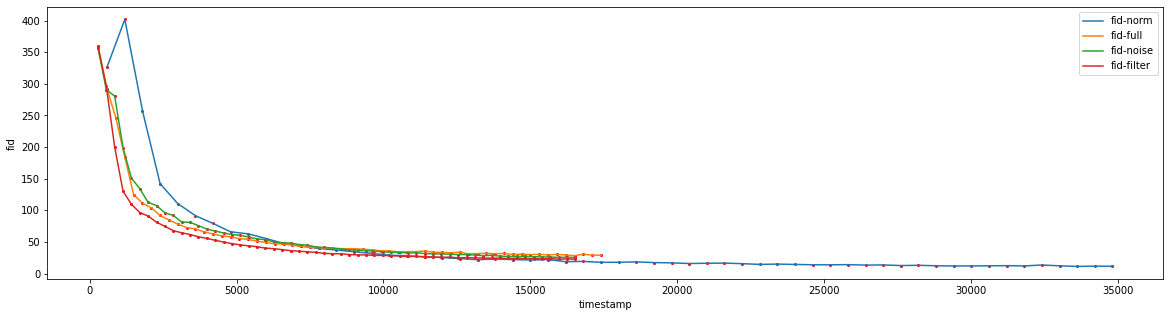

In [8]:
plot([norm_fid, full_fid, noise_fid, filter_fid], ['norm', 'full', 'noise', 'filter'], ['fid'], markers = True, ylabel = 'fid', log = False)

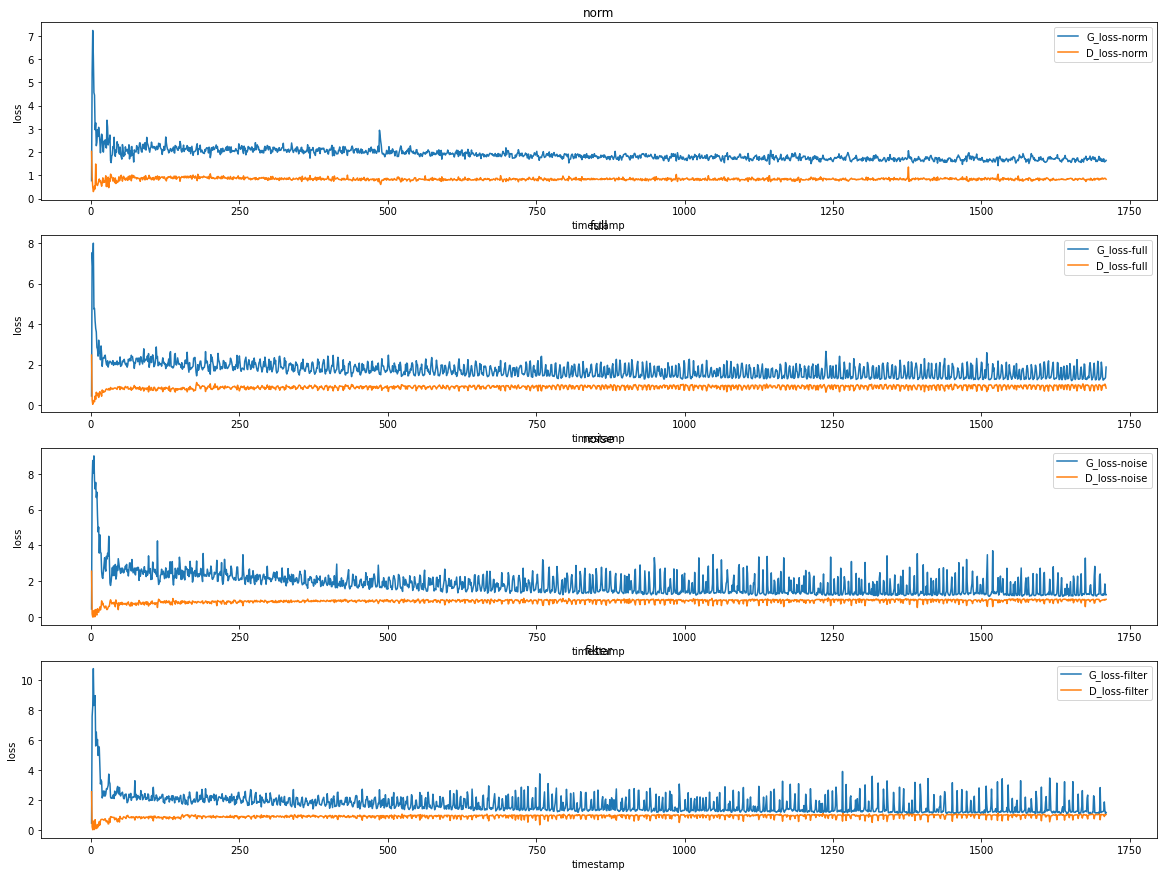

In [10]:
plot([norm_loss, full_loss, noise_loss, filter_loss], ['norm', 'full', 'noise', 'filter'], ['G_loss', 'D_loss'], split = True, figsize = (20, 15), ylabel = 'loss')

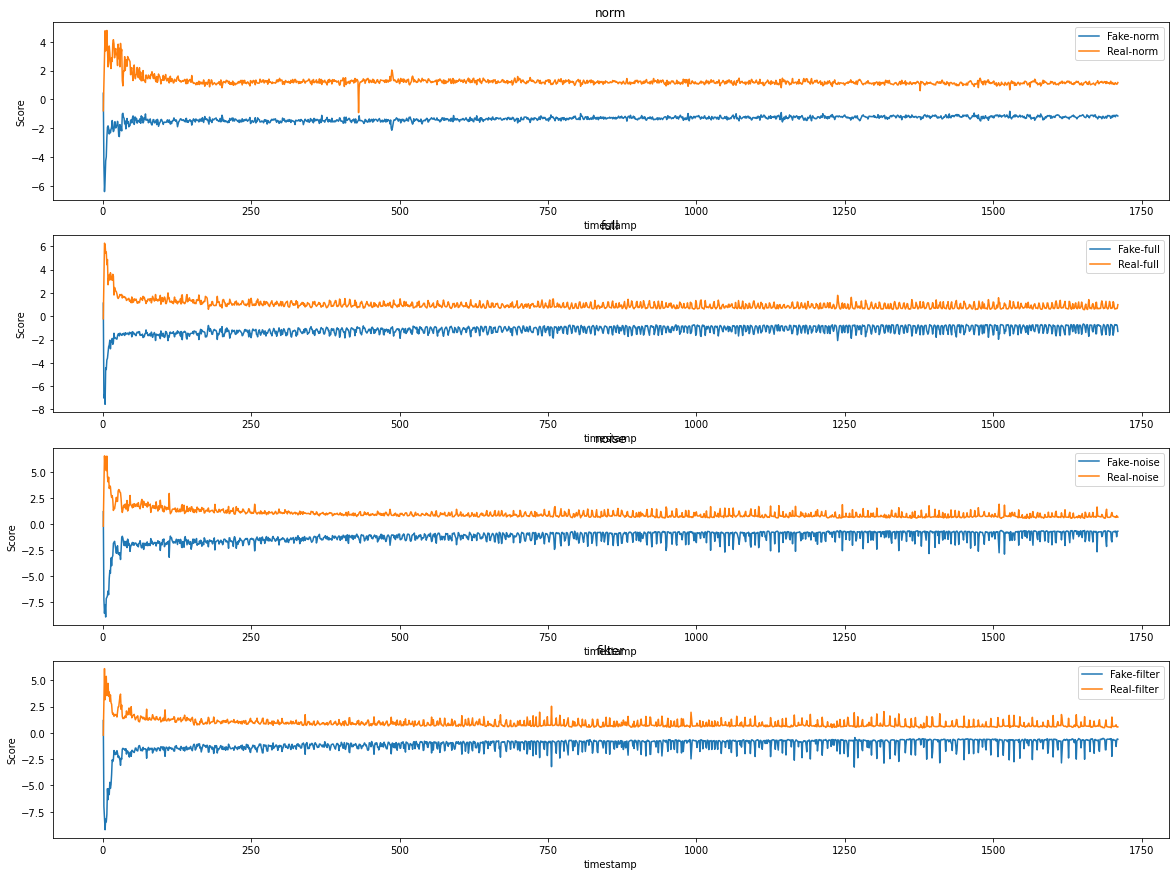

In [11]:
plot([norm_loss, full_loss, noise_loss, filter_loss], ['norm', 'full', 'noise', 'filter'], ['Fake', 'Real'], split = True, figsize = (20, 15), ylabel = 'Score')